#  Ideal bandwidths and PDF functions 

Based on kde_tutorial from https://notebooks.gesis.org/binder/jupyter/user/saint-germain-p-ation_synthesis-uu00810x/tree/prep

### Libraries and data
The data trataiment:

In [47]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.stats import gaussian_kde

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
import warnings
warnings.simplefilter('ignore')

In [50]:
dn=pd.read_csv('data/proc_no_pert.csv',index_col=None) #without pertubtations 
dn["gia"]=dn.ngi>0
dl=pd.read_csv('data/proc_lo_pert.csv',index_col=None) #with low pertubtations 
dl["gia"]=dl.ngi>0
dh=pd.read_csv('data/proc_hi_pert.csv',index_col=None) #with high pertubtations 
dh["gia"]=dh.ngi>0

In [51]:
#Terrestrial
dnt=dn[~dn["gia"]] # without pertubtations 
dlt=dl[~dl["gia"]] # low pertubtations 
dht=dh[~dh["gia"]] # high pertubtations 

#Giant 
dng=dn[dn["gia"]]  # without pertubtations 
dlg=dl[dl["gia"]]  # low pertubtations 
dhg=dh[dh["gia"]]  # high without pertubtations 

In [52]:
print("***************************************")
print("Total systems                  : "+str(len(dn)))
print("***************************************")
print("Total planets - no             : "+str(dn.nplanets.sum().astype(int)))
print("Giant planets - no             : "+str(dn.ngi.sum().astype(int)))
print("Systems with giant planets - no: "+str(dn.gia.sum()))
print("***************************************")

print("Total planets - lo             : "+str(dl.nplanets.sum().astype(int)))
print("Giant planets - lo             : "+str(dl.ngi.sum().astype(int)))
print("Systems with giant planets - lo: "+str(dl.gia.sum()))
print("***************************************")
print("Total planets - hi             : "+str(dh.nplanets.sum().astype(int)))
print("Giant planets - hi             : "+str(dh.ngi.sum().astype(int)))
print("Systems with giant planets - hi: "+str(dh.gia.sum()))

***************************************
Total systems                  : 1221
***************************************
Total planets - no             : 15887
Giant planets - no             : 330
Systems with giant planets - no: 268
***************************************
Total planets - lo             : 15732
Giant planets - lo             : 374
Systems with giant planets - lo: 306
***************************************
Total planets - hi             : 15441
Giant planets - hi             : 388
Systems with giant planets - hi: 309


In [53]:
x_variables = [dng,dlg,dhg,dnt,dlt,dht,dn,dl,dh]

for i, var in enumerate(x_variables):
    var['logeff'] = np.log10(var.massefficiency)
    var['logcom'] = np.log10(var.com)

In [54]:
dnt.head()

Unnamed: 0  ident       com  nplanets  massbudget  massefficiency  \
1           1    5.0  2.932894      12.0   17.882769        0.000488   
3           3    8.0  5.740174       9.0    8.166382        0.000163   
5           5   15.0  8.394027       8.0   16.003091        0.000436   
6           6   16.0  4.289089      24.0   12.426573        0.000219   
7           7   17.0  3.771156      12.0   16.762554        0.000811   

      sigmag0     md         rc        ms     metal        taugas      qest  \
1  102.431593  0.110  38.977428  1.075269 -0.150160  1.014449e+06  5.464831   
3   62.737337  0.150  58.158928  1.076658 -0.282408  6.017040e+06  4.704798   
5  106.824759  0.110  38.167542  0.986003  0.388613  2.435406e+06  5.218175   
6  118.543720  0.170  45.042137  1.258747 -0.352459  1.107032e+06  4.469478   
7   35.587738  0.062  49.645451  0.739731  0.121866  9.050091e+06  7.257983   

   ngi        mtr  apert    gia    logeff    logcom  
1  0.0  17.882769    0.0  False -3.311837  0.467296  
3  0.0   8.166382    0.0  False -3.786940  0.758925  
5  0.0  16.003091    0.0  False -3.360068  0.923970  
6  0.0  12.426573    0.0  False -3.658976  0.632365  
7  0.0  16.762554    0.0  False -3.090930  0.576474

Some important variables: 

## Bandwidth problem
So far we have our data. Now we need to construct their probability density distributions. To do this we employ Kernel Density Estimation (KDE), here the bandwidth take importance. Let's study how to estimate the shape $\widehat{f}_{h}(x)$ of the funtion which could represents the probability density function: 

$$\widehat{f}_{h}(x)=\frac{1}{n} \sum_{i=1}^{n} K_{h}\left(x-x_{i}\right)=\frac{1}{n h} \sum_{i=1}^{n} K\left(\frac{x-x_{i}}{h}\right).$$

Here $K_{h}$ is a kernel (non-negative function), commonly used: uniform, triangular, biweight, triweight, Epanechnikov, normal, among others. The $h$ parameters is a smoothing constant, it is also called _bandwidth_ (mor information of KDE <a href="https://cran.r-project.org/web/packages/kedd/vignettes/kedd.pdf">here</a>). 
 

### The Bandwidth definition
A very brief definition, from <a href="https://en.wikipedia.org/wiki/Kernel_density_estimation">wikipedia</a>: The bandwidth of the kernel is a free parameter which exhibits a strong influence on the resulting estimate. T

The most common optimality criterion used to select this parameter is the expected risk function employing cross validation: 

$$\operatorname{MISE}(h)=\mathrm{E}\left[\int\left(\hat{f}_{h}(x)-f(x)\right)^{2} d x\right].$$

Also is used the rule-of-thumb bandwidth estimator:

$$h=\left(\frac{4 \hat{\sigma}^{5}}{3 n}\right)^{\frac{1}{5}} \approx 1.06 \hat{\sigma} n^{-1 / 5}.$$

Or Silverman's (1986) rule of thumb:

$$h=0.9 \min \left(\hat{\sigma}, \frac{I Q R}{1.34}\right) n^{-\frac{1}{5}}.$$

Some considrations in the values of $h$. On the one hand, if $h\rightarrow 0$ then we have overfitting, in other words there is no smoothing (plots like sum of delta fuctions).  On the other hand, if $h\rightarrow \infty$, we have a density function completily smoothed.

Now, let's estudy some examples with `cross_validation` and `gaussian_kde`: 

In [81]:
# an example with kernel density
x=dng.ngi
grid = GridSearchCV(KernelDensity(), 
                    {'bandwidth': np.linspace(x.min(),x.max()/100,100)},
                    cv=50) # 20-fold cross-validation
grid.fit(x[:, None])
#print(grid.best_params_)

# other example with gaussian_kde method. 
kde = gaussian_kde(x)
f = kde.covariance_factor()
bw = f * x.std()
#print("bw g_kde: "+str(bw))

A comparison plot

(array([2.71144279, 0.        , 0.        , 0.49751244, 0.        ,
        0.        , 0.09950249, 0.        , 0.        , 0.02487562]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

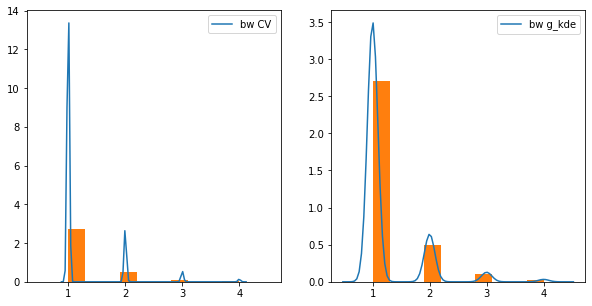

In [82]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

sns.kdeplot(dng.ngi, bw=grid.best_params_['bandwidth'], ax=axes[0], label="bw CV"); 
axes[0].hist(dng.ngi, density=True)

sns.kdeplot(dng.ngi,bw=bw, ax=axes[1],label="bw g_kde"); 
axes[1].hist(dng.ngi, density=True)

Now we introduce a new funtoion that obtain the bandwidths through `Gaussian_kde` and `KernelDensity`. Then, the optimal bandwidhts came from `bw_opt` function:

In [57]:
#The variable is a column from dataFrames: 'dng','dlg','dhg','dnt','dlt','dht','dn','dl','dh'
def bw_opt(variable, name, plot=False):

    m=.2; dvariable=0.05; deciamls=2
    
    x = variable/variable.min() 
    x_grid = np.around(np.arange(x.min()-m,x.max()+m,dvariable),deciamls)
    norm, size, cv = 10, 30, 30 # 30-fold cross-validation     
        
    #-------------With CrossValidation:
    #x = 
    grid = GridSearchCV(KernelDensity(), 
                        {'bandwidth': np.linspace(x.min(),x.max()/\
                                                  norm,size)},
                        cv=cv) # max-min (grid)
    grid.fit(x[:, None])
    kde_CV = grid.best_estimator_
    bw_CV  = list(grid.best_params_.values())[0]
    pdf_CV = np.exp(kde_CV.score_samples(x_grid[:,None]))
    
    #-------------Gaussian_KDE:
    kde_G = gaussian_kde(x)
    f = kde.covariance_factor()
    bw_KDE =  f * x.std()
    pdf_kde = kde_G.evaluate(x_grid)
    
    #---------Comparative plot: 
    if plot == True: 
        fig, ax = plt.subplots(1,3, figsize=(11, 4), constrained_layout=True, sharex=True, sharey=True)
        #-------CV_plot:
        ax[0].plot(x_grid, pdf_CV, linewidth=2, label='bw=%.4f'%kde_CV.bandwidth)
        ax[0].hist(x,8,density=True, alpha=.3)
        ax[0].legend(loc="upper right")
        ax[0].set_title("Cross Validation")
        #-------kde_plot:
        ax[1].plot(x_grid, pdf_kde, linewidth=2, label='bw=%.4f'%bw_KDE)
        ax[1].hist(x,8,density=True, alpha=.3)
        ax[1].legend(loc="upper right")
        ax[1].set_title("Gausian_kde")
        #-------sns_plot:
        sns.distplot(x,  ax=ax[2], axlabel=False, bins=8,
                     hist_kws={"alpha": .3, "color": 'C1'}, 
                     label='default distplot') 
        ax[2].legend(loc="upper right")
        ax[2].set_title("displot")
        #---------------
        fig.suptitle("variable: "+name, 
                     fontsize=15, horizontalalignment='center')
        plt.show()
    return [bw_CV, bw_KDE]

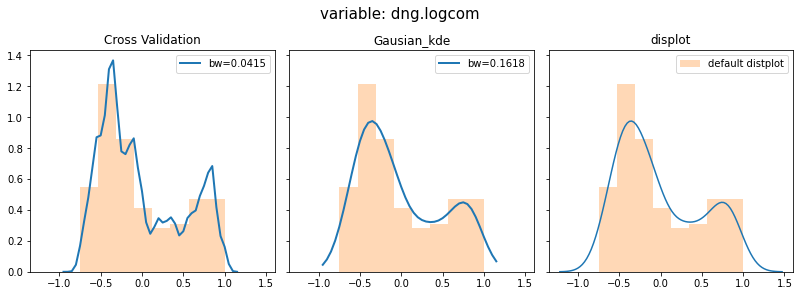

In [58]:
dng_logcom = bw_opt(dhg.logcom, name="dng.logcom", plot=True)

To determine the optimar bw for all data, we can uncomment the following lines 

In [84]:
#%%time
#x_variables = [dng,dlg,dhg,dnt,dlt,dht,dn,dl,dh]
#names       = ["dng","dlg","dhg","dnt","dlt","dht","dn","dl","dh"]
#opt_bw_eff  = [] 
##opt_bw_logcom  = [] 

#for index,variable in enumerate(x_variables):
#    print(names[index]+"."+str(variable.logeff.name))
#    bw = bw_opt(variable.logeff, names[index], plot=True)
#    opt_bw_eff.append(bw)

### Optimal bw and PDF

Now, we stablish a better way to determinie the bw and the pdf for each variable. To do this, we implement the `KernelDansity` (through `SearchGridCV`) and `gaussian_kde` as methods of a new class `optimal_bw`. Here we standarize the data. 
#### Standarization
We standarize the data in order to compare it. It also heps to determine the ideal bandwith in the search vector of `GridSearchCV`. Therefore, 

- **Standarization**: It is another scaling technique where the values are centered around the mean with a unit standard deviation. 
$$X^{\prime}=\frac{X-\mu}{\sigma}$$

#### GridSearchCV Method
We use `GridSearchCV` to estimate the otimal bw. As the best splitting strategy in cross validation, we take cv$=10$, according with documentaction split the data in more grups is not orthodox, because it does not allow the method to learn with a larger data set.

Finally, in the grid search we employ `KernelDensity` with a Gaussian kernel. 
##### The search vector
In the `GridSearchCV` method we use a search vector to determine the optimal bw. The minimum distance between data is the initial value in the serarch vector. As maximum value of serach we use $3\sigma$ of our data (remember that data are standarized). Finally, the number of steps in the search vector is taken as the ideal for the score of `KernelDensity`.   

#### gaussian_kde  Method
we use this method as is described in the documentation. 

In [124]:
class optimal_bw(object):
    
    def __init__(self, variable):
        
        dx, length, deciamls = .2, 100, 2 #some constants for the grid of space
        self.variable = variable.values   #original variable
        
        self.x = (self.variable-self.variable.mean())\
        /self.variable.std()              #standarization:
        #grid for the pdf
        self.x_grid = np.around(np.linspace(self.x.min()-dx,
                                            self.x.max()+dx,length),deciamls)
        
        m = np.abs(np.diff(self.x))       #distance between data
        self.min = min(m[m>0])
        
    def cv_pdf(self):
        cv, nsteps = 10, 30
        grid = GridSearchCV(KernelDensity(),
                            {'bandwidth': np.linspace(self.min, 
                                                      3*self.x.std(), 
                                                      nsteps)}, cv=cv)
        grid.fit(self.x[:, None])
        
        self.bw_CV  = grid.best_estimator_.bandwidth        
        self.pdf_CV = np.exp(grid.best_estimator_.score_samples(self.x_grid[:,None]))
        
    def kde_pdf(self):
        kde_G = gaussian_kde(self.x)

        self.bw_KDE =  kde_G.covariance_factor()*self.x.std()
        self.bw2 = self.bw_KDE*self.variable.std()+self.variable.mean()    #bw in data space (autside of standarization)
        
        self.pdf_kde = kde_G.evaluate(self.x_grid)

In [117]:
ex = optimal_bw(dlg.logeff)
ex.cv_pdf()
ex.kde_pdf()

Now, we make a funtion that generates the comparative plot between `gaussian_kde` and `GridSearchCV` methods of `optimal_bw`.

In [118]:
#needs an object from class bw_optimal
def pdfs_plot(bw):
    
    nbins=25
    #print('dx_min=%.3f'%bw.min)
    fig, ax = plt.subplots(1,3, figsize=(14, 4), 
                           constrained_layout=True, sharey=True)

    ax[0].plot(bw.x_grid, bw.pdf_CV, linewidth=2, label='bw=%.3f'%bw.bw_CV)
    ax[0].hist(bw.x, nbins, density=True, alpha=.3, label="standarized data")
    ax[0].legend(loc="upper left")
    ax[0].set_title("Cross Validation")
    
    sns.distplot(bw.variable, ax=ax[1], bins=nbins,
                 kde_kws={'bw':bw.bw_CV,'label':'pdf in original data','color':'C1'},
                 hist_kws = {'density':'True','label':'Original data'})
    ax[1].legend(loc="upper left")
    
    ax[2].plot(bw.x_grid, bw.pdf_kde, linewidth=2, label='bw=%.3f'%bw.bw_KDE)
    ax[2].hist(bw.x,nbins,density=True, alpha=.3, label="standarized data")
    ax[2].legend(loc="upper left")
    ax[2].set_title("Gausian_kde")

So, an example of implementing the methods from `bw_optimal` and its plot

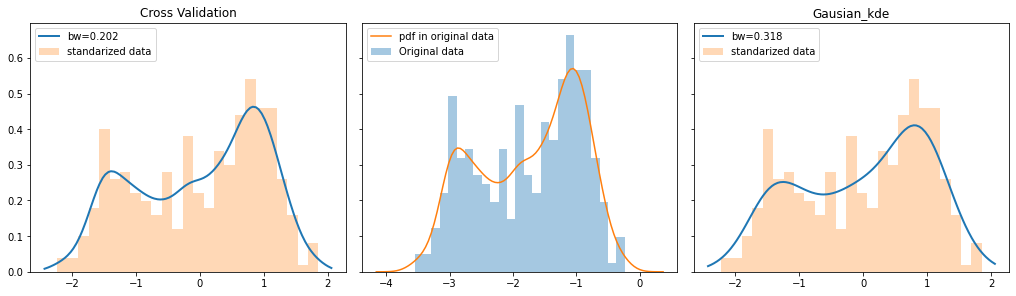

In [125]:
plot = pdfs_plot(ex)

For all the information in the variable `x_variables`

In [127]:
x_variables = [dng,dlg,dhg,dnt,dlt,dht,dn,dl,dh]

#for index,variable in enumerate(x_variables):
#    #print(names[index]+"."+str(variable.logcom.name))
#    bw = optimal_bw(variable.logeff)
#    bw.cv_pdf()
#    bw.kde_pdf()
#    plot = pdfs_plot(bw)

## Bandwiths for  2-D and 3-D
We are going to study the bw problem for more than one dimension

### 2D Example
For 2d, we have the function:

In [65]:
def uni_kde(x,y,tickno=5,nlev=30):
    
    x_grid=np.around(np.arange(x.min(),x.max(),0.1),2)
    y_grid=np.linspace(y.min(),y.max(),len(x_grid))
    conv=(x.max()-x.min())/(y.max()-y.min())
    yori=y
    y=y*conv
    y_grid=y_grid*conv
    
    grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(x.min(),x.max()/10,30)},
                    cv=20) # 20-fold cross-validation
    
    grid.fit(np.vstack([x,y]).T)
    
    print(grid.best_params_)
    
    X, Y = np.meshgrid(x_grid, y_grid)
  
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    
    kde2d = grid.best_estimator_
    pdf2d = np.exp(kde2d.score_samples(xy)).reshape(X.shape) #get the pdf
    
    plt.figure(figsize=(5,5))
    levels = np.linspace(0, pdf2d.max(), nlev)
    plt.contourf(X, Y, pdf2d, levels=levels, cmap=plt.cm.Reds)
    
    old_ticks=np.linspace(y.max(), y.min(), tickno)
    major_ticks = 10**np.linspace(yori.max(), yori.min(), tickno)
    myticks=[]
    for i in major_ticks:
        myticks+=["%.e"%i]
    e=plt.yticks(old_ticks,myticks) 

similar function that has standarized data and emply the methods in the class `optimal_bw`

In [128]:
#needs two objects from class bw_optimal, which are normalized or standarized 
def bi_kde(data_x,data_y):
    
    x_grid = data_x.x_grid
    y_grid = data_y.x_grid
    print(data_x.min)
    
    #grid = KernelDensity() # para hacer pruebas
    
    grid = GridSearchCV(KernelDensity(), 
                        {'bandwidth': np.linspace(data_x.min,
                                                  3*data_x.x.std(),
                                                  50)}, cv=10)
    #xx = np.vstack([data_x.x,data_y.x]).T
    #print(len(xx))
    grid.fit(np.vstack([data_x.x,data_y.x]).T)
    print(grid.best_params_)
    
    X, Y = np.meshgrid(x_grid, y_grid)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    #print(len(xy))
    kde2d = grid.best_estimator_
    pdf2d = np.exp(kde2d.score_samples(xy)).reshape(X.shape) #get the pdf
    
    plt.figure(figsize=(5,5))
    plt.contourf(X, Y, pdf2d, levels=30, cmap=plt.cm.Reds)
    
    return pdf2d

{'bandwidth': 0.09996864449290914}
0.0038828390935070622
{'bandwidth': 0.24846383182056772}


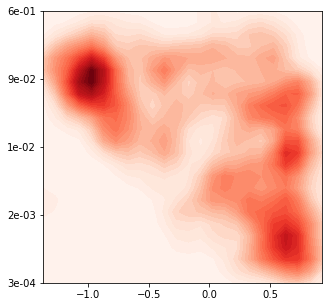

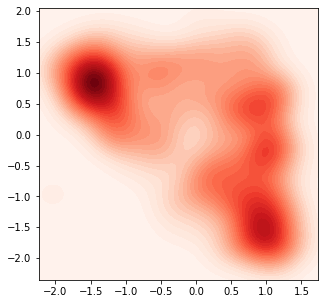

In [129]:
uni_kde(dng.logcom, dng.logeff)
ex_2d = bi_kde(optimal_bw(dng.logcom),optimal_bw(dng.logeff))

### 3D example

Just an example with 3 variables, without standardized and standarized data. 

In [130]:
from mpl_toolkits import mplot3d
#---------------------Data:
x = dng.logeff/dng.logeff.min()
y = dng.logcom#/dng.logcom.min()
z = dng.nplanets

data = np.vstack((x,y,z)).T
#---------------------Grid:
x_grid=np.around(np.linspace(x.min(),x.max(),30),2)
y_grid=np.linspace(y.min(),y.max(),len(x_grid))
z_grid=np.linspace(z.min(),z.max(),len(x_grid))

X,Y,Z = np.meshgrid(x_grid, y_grid, z_grid)
xyz   = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T
#----------------------CV:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(x.min(),x.max()/10,30)},
                    cv=20) # 20-fold cross-validation
grid.fit(data)
    
kde3d_1 = grid.best_estimator_
pdf3d_1 = np.exp(kde3d_1.score_samples(xyz)).reshape(X.shape) #get the pdf

In [135]:
density_1 = pdf3d_1.ravel()
#fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
#x, y, z = X.ravel(), Y.ravel(), Z.ravel()
#ax.scatter(x, y, z, c=density_1, alpha=1, cmap= 'seismic',
#           vmin=-np.abs(np.max(density_1)),vmax=np.abs(np.max(density_1)))

In [136]:
#import plotly.graph_objects as go
#fig = go.Figure(data=go.Volume(
#    x=X.flatten(),
#    y=Y.flatten(),
#    z=Z.flatten(),
#    value=density_1.flatten(),
#    opacity=0.1, # needs to be small to see through all surfaces
#    surface_count=25, # needs to be a large number for good volume rendering
#    ))
#fig.show()

In [138]:
#---------------------Data:
x2 = (dng.logeff-dng.logeff.mean())/dng.logeff.std()
y2 = (dng.logcom-dng.logcom.mean())/dng.logcom.std()
z2 = (dng.nplanets-dng.nplanets.mean())/dng.nplanets.std()
#z2 = dng.nplanets

data2 = np.vstack([x2,y2,z2]).T

#---------------------Grid:
x2_grid=np.around(np.linspace(x2.min(),x2.max(),30),2)
y2_grid=np.linspace(y2.min(),y2.max(),len(x2_grid))
z2_grid=np.linspace(z2.min(),z2.max(),len(x2_grid))

X2,Y2,Z2 = np.meshgrid(x2_grid, y2_grid, z2_grid)
xyz2   = np.vstack([X2.ravel(), Y2.ravel(), Z2.ravel()]).T

var_min=[x2.min(),y2.min(),z2.min()]
var_max=[x2.max(),y2.max(),z2.max()]

#----------------------CV:

grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(min(var_min),max(var_max),50)},
                    cv=20) # 20-fold cross-validation
grid.fit(data2)

kde3d_2 = grid.best_estimator_
pdf3d_2 = np.exp(kde3d_2.score_samples(xyz2)).reshape(Z2.shape) #get the pdf

A comparative plot, employing `plotly`.

In [140]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

density_2 = pdf3d_2.ravel()

fig = make_subplots(rows=1, cols=2,  
                    specs=[[{'type': 'volume'}, {'type': 'volume'}]])

fig.add_trace(
    
    go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=density_1.flatten(),
    opacity=0.1,     # needs to be small to see through all surfaces
    surface_count=25 # needs to be a large number for good volume rendering
    ), 
    row=1, col=1
)
fig.update_layout(height=500, showlegend=False)

fig.add_trace(
    
    go.Volume(
    x=X2.flatten(),
    y=Y2.flatten(),
    z=Z2.flatten(),
    value=density_2.flatten(),
    opacity=0.1,     # needs to be small to see through all surfaces
    surface_count=25 # needs to be a large number for good volume rendering
    ), 
    row=1, col=2
)
fig.update_layout(height=500, showlegend=False)


fig.show()


## Multidimensional case

It is time to obtain the bw and the PDF for any dimensionality. At this point, we use the `GridSearchCV` for the `KernelDensity`, to obtain the ideal bw and the PDF function. 

The search vector has the same the same spirit: an initial value which is the minimum disntance betweeen the data and 3 times the standard deviation of our normalized data. Finally, the number of steps in the search vector is taken as the ideal for the optimal score of `KernelDensity`. 

Again, we will use as the best splitting strategy in cross validation cv$=10$.

In [73]:
# var_ means "variables", e.g. var_grids represents the different grids for each variable
class multidim_bw(object):

    def __init__(self, *args):
        
        dx, length, deciamls = .2, 100, 2    # some constants for the grid of space
        self.diffmin    = []                 # it will keep information of min and max values  
        self.var_values = []                 # Their components are objects from class bw_optimal
        self.var_grids  = [] 
        
        
        for i in range(len(args)):           # It calls the class bw_optimal to standarize data                          
            # standarization
            self.x = (args[i].values -args[i].values.mean())/args[i].values.std()  
        
            self.x_grid = np.around(np.linspace(self.x.min()-dx,
                                                self.x.max()+dx,
                                                length),deciamls)             
            
            self.var_values.append(self.x)     # std values
            self.var_grids.append(self.x_grid) # lists of x_grids  
            
            #distance between data
            m = np.abs(np.diff(self.x))
            self.diffmin.append(min(m[m>0]))
            
        self.data   = np.vstack([*self.var_values]).T 
        
        self.n_grid = np.meshgrid(*self.var_grids)
        ll = [self.n_grid[i].ravel() for i in range(len(self.n_grid))]
        self.space  = np.vstack([*ll]).T   # It generates the space for the pdf

    def pdf_ndim(self):
        self.grid = GridSearchCV(KernelDensity(),
                                param_grid={'bandwidth': np.linspace(min(self.diffmin), 
                                                           3*self.x.std(),
                                                           25)}, cv=5)
        self.grid.fit(self.data)
        
        self.ndim_bw  = self.grid.best_estimator_.bandwidth
        self.ndim_pdf = np.exp(self.grid.best_estimator_.score_samples(self.space).reshape(self.n_grid[0].shape))  #get the pdf
        
        #with open(str(len(self.var_values))+"dim_pdf.txt","w") as out_file:
        #    for i in range(len(self.ndim_pdf.ravel())):
        #        out_file.write(str(self.ndim_pdf.ravel()[i])+"\n")
        

In [74]:
%%time
ex2 = multidim_bw(dng.logcom, dng.logeff)#, dng.nplanets, dng.metal, dng.massefficiency)
ex2.pdf_ndim()

CPU times: user 378 ms, sys: 6.72 ms, total: 385 ms
Wall time: 372 ms


0.25355926916904814


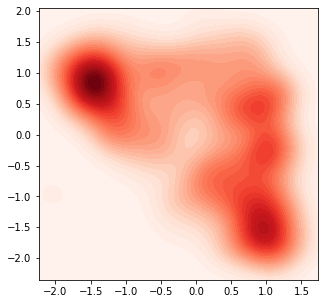

In [75]:
print(ex2.ndim_bw)
plt.figure(figsize=(5,5))
plt.contourf(ex2.n_grid[0], ex2.n_grid[1], ex2.ndim_pdf, levels=30, cmap=plt.cm.Reds)

In [76]:
obs1 = dng.logcom.sample(100)
obs2 = dng.logeff.sample(100)
obs = pd.concat([obs1 , obs2], axis = 1).dropna()
#obs

In [77]:
Prob = np.exp(ex2.grid.best_estimator_.score_samples(obs))
Prob

array([5.47383301e-02, 3.83561054e-02, 4.69952932e-04, 1.18585032e-03,
       5.15720317e-03, 6.91401470e-02, 9.87068615e-04, 3.48420694e-10,
       1.05820657e-01, 1.46920841e-03, 1.81528467e-03, 7.08964331e-02,
       8.26353641e-03, 2.61988702e-02, 4.54390703e-05, 1.01843934e-02,
       1.20925787e-01, 7.41539168e-03, 1.58747585e-05, 1.03414926e-01,
       8.26644268e-02, 9.28342834e-04, 4.39317336e-02, 1.34746532e-01,
       3.36106070e-02, 3.13602728e-02, 2.79992553e-02, 1.55512843e-01,
       1.08842031e-04, 1.06519113e-05, 2.67885105e-06, 8.79263182e-06,
       2.17677050e-03, 3.00921663e-05, 5.42821705e-02, 1.39961942e-02])

In [78]:
prior = np.random.normal(dng.logcom.mean(), dng.logcom.std(), len(Prob))
#prior 

In [79]:
posterior = Prob*prior

(array([ 1.,  5.,  5., 18.,  2.,  1.,  2.,  0.,  1.,  1.]),
 array([-0.04426157, -0.03144218, -0.01862279, -0.0058034 ,  0.00701598,
         0.01983537,  0.03265476,  0.04547415,  0.05829353,  0.07111292,
         0.08393231]),
 <a list of 10 Patch objects>)

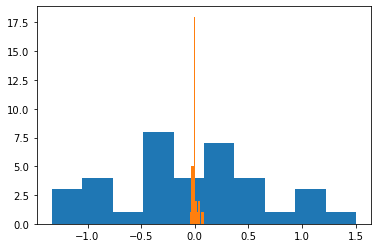

In [80]:
plt.hist(prior)
plt.hist(posterior)

In [36]:
#plt.figure(figsize=(5,5))
#plt.contourf(ex2.n_grid[0], ex2.n_grid[1], ex2.ndim_pdf, levels=30, cmap=plt.cm.Reds)

In [37]:
#ex2.ndim_bw

In [38]:
len(dng.logeff)

268